In [1]:
!pip install tensorflow==2.0.0rc0 &> log
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 3.9MB 45.7MB/s 
     |████████████████████████████████| 450kB 52.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=4257dff8918d84b32afa995da889118b1627aae808d1c5591949242c4e4c997a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0


In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar -xzf imagenette2.tgz

--2020-04-04 10:36:38--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.82.28
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.82.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556914727 (1.4G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  35.0MB/s    in 43s     

2020-04-04 10:37:22 (34.2 MB/s) - ‘imagenette2.tgz’ saved [1556914727/1556914727]



In [0]:
import revnet
import ops
import blocks

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 3)
  config.add_hparam("n_res", [3, 3, 3])
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 0)
  
  return config

In [23]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


## Check invertibility

In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)

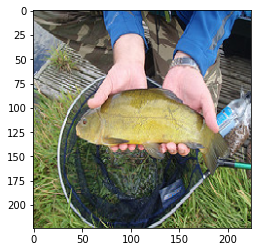

In [25]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

new_y = tf.concat([logits, nuisance], axis=1)
res_x = model.get_x(new_y)

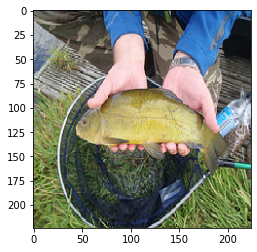

In [26]:
plt.imshow(x[0])

In [27]:
np.max(abs(res_x - x0[0]))

1.8000603e-05

## Receptive field:

In [28]:
zeros = np.zeros((1, *config.input_shape))
zeros = tf.convert_to_tensor(zeros, dtype=config.dtype)
zeros_logits, _ = model(zeros, training=False)

shift = 4
size = 10
for x_step in range(config.input_shape[0] // shift):
  for y_step in range(config.input_shape[0] // shift):
    curr = np.zeros((1, *config.input_shape))
    curr[:, x_step*shift:x_step*shift + size, y_step*shift:y_step*shift + size,  :] = 1.

    curr = tf.convert_to_tensor(curr, dtype=config.dtype)
    curr_logits, _ = model(curr, training=False)
    if np.sum(np.abs(zeros_logits.numpy() - curr_logits.numpy())) == 0:
      print("Coordinates with zero diff: x - ", x_step*shift, " y - ", y_step*shift)
      break

Coordinates with zero diff: x -  0  y -  36
Coordinates with zero diff: x -  4  y -  36
Coordinates with zero diff: x -  8  y -  36
Coordinates with zero diff: x -  12  y -  36
Coordinates with zero diff: x -  16  y -  36
Coordinates with zero diff: x -  20  y -  36
Coordinates with zero diff: x -  24  y -  36
Coordinates with zero diff: x -  28  y -  36
Coordinates with zero diff: x -  32  y -  36
Coordinates with zero diff: x -  36  y -  0
Coordinates with zero diff: x -  40  y -  0
Coordinates with zero diff: x -  44  y -  0
Coordinates with zero diff: x -  48  y -  0
Coordinates with zero diff: x -  52  y -  0
Coordinates with zero diff: x -  56  y -  0
Coordinates with zero diff: x -  60  y -  0
Coordinates with zero diff: x -  64  y -  0
Coordinates with zero diff: x -  68  y -  0
Coordinates with zero diff: x -  72  y -  0
Coordinates with zero diff: x -  76  y -  0
Coordinates with zero diff: x -  80  y -  0
Coordinates with zero diff: x -  84  y -  0
Coordinates with zero diff

Таким образом, мы видим, что рецептивное поле для первых 10 логитов - это примерно левый верхний угол размером 32 на 32 пикселя. Попробуем увеличить глубину сети:

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 50)
  config.add_hparam("n_res", [1] * 50)
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 0)
  
  return config

In [30]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [37]:
zeros = np.zeros((1, *config.input_shape))
zeros = tf.convert_to_tensor(zeros, dtype=config.dtype)
zeros_logits, _ = model(zeros, training=False)

shift = 4
size = 10
for x_step in range(config.input_shape[0] // shift):
  curr = np.zeros((1, *config.input_shape))
  curr[:, x_step*shift:x_step*shift + size, x_step*shift:x_step*shift + size,  :] = 1.

  curr = tf.convert_to_tensor(curr, dtype=config.dtype)
  curr_logits, _ = model(curr, training=False)
  if np.sum(np.abs(zeros_logits.numpy() - curr_logits.numpy())) == 0:
    print("Coordinates with zero diff: x - ", x_step*shift, " y - ", x_step*shift)

Coordinates with zero diff: x -  92  y -  92
Coordinates with zero diff: x -  96  y -  96
Coordinates with zero diff: x -  100  y -  100
Coordinates with zero diff: x -  104  y -  104
Coordinates with zero diff: x -  108  y -  108
Coordinates with zero diff: x -  112  y -  112
Coordinates with zero diff: x -  116  y -  116
Coordinates with zero diff: x -  120  y -  120
Coordinates with zero diff: x -  124  y -  124
Coordinates with zero diff: x -  128  y -  128
Coordinates with zero diff: x -  132  y -  132
Coordinates with zero diff: x -  136  y -  136
Coordinates with zero diff: x -  140  y -  140
Coordinates with zero diff: x -  144  y -  144
Coordinates with zero diff: x -  148  y -  148
Coordinates with zero diff: x -  152  y -  152
Coordinates with zero diff: x -  156  y -  156
Coordinates with zero diff: x -  160  y -  160
Coordinates with zero diff: x -  164  y -  164
Coordinates with zero diff: x -  168  y -  168
Coordinates with zero diff: x -  172  y -  172
Coordinates with 

Таким образом, с данной глубиной сети рецептивное поле - примерно половина изображения. При увеличении глубины сети возникают очень большие погрешности и сеть перестает быть обратимой, что показано ниже.

In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)

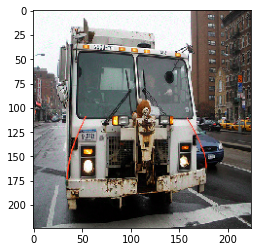

In [33]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

new_y = tf.concat([logits, nuisance], axis=1)
res_x = model.get_x(new_y)

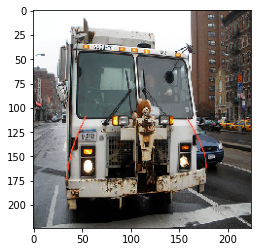

In [34]:
plt.imshow(x[0])

In [35]:
np.max(abs(res_x - x0[0]))

0.22431368

## Space to depth:

Воспользуемся методом tf.nn.space_to_depth для увеличения рецептивного поля и для сохранения обратимости модели:

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 6)
  config.add_hparam("n_res", [3] * 6)
  config.add_hparam("ratio", [2, 2, 2, 1, 1, 1])
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 0)
  
  return config

In [6]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)

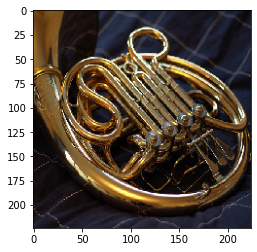

In [8]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

new_y = tf.concat([logits, nuisance], axis=1)
res_x = model.get_x(new_y)

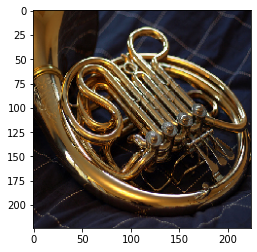

In [9]:
plt.imshow(x[0])

In [10]:
np.max(abs(res_x - x0[0]))

0.0026847273

Модель достаточно обратима.

In [0]:
zeros = np.zeros((1, *config.input_shape))
zeros = tf.convert_to_tensor(zeros, dtype=config.dtype)
zeros_logits, _ = model(zeros, training=False)

shift = 4
size = 10
for x_step in range(config.input_shape[0] // shift):
  curr = np.zeros((1, *config.input_shape))
  curr[:, x_step*shift:x_step*shift + size, x_step*shift:x_step*shift + size,  :] = 1.

  curr = tf.convert_to_tensor(curr, dtype=config.dtype)
  curr_logits, _ = model(curr, training=False)
  if np.sum(np.abs(zeros_logits.numpy() - curr_logits.numpy())) == 0:
    print("Coordinates with zero diff: x - ", x_step*shift, " y - ", x_step*shift)

РецеРецептивное поле - всё изображение

## LRFinder

In [0]:
tqdm.tqdm._instances.clear()

In [61]:
import tensorflow.keras.backend as K
import math
import tqdm 

start_lr = 0.00001
end_lr = 100
max_val_acc = None
lr = start_lr
lr_mult = (end_lr / start_lr) ** (1 / int(np.ceil(train.samples / train.batch_size)))
lrs = []
losses = []
best_loss = 1e9

optimizer = tf.keras.optimizers.SGD(learning_rate=start_lr)

for step in tqdm.trange(int(np.ceil(train.samples / train.batch_size))):
    x_batch_train, y_batch_train = train.next()

    grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
    optimizer.apply_gradients(zip(grads, vars_))

    lrs.append(lr)
    losses.append(loss)

    if math.isnan(loss) or loss > best_loss * 1000:
        break
    
    if loss < best_loss:
        best_loss = loss

    lr *= lr_mult
    K.set_value(optimizer.lr, lr)

 80%|████████  | 237/296 [20:33<05:05,  5.18s/it]

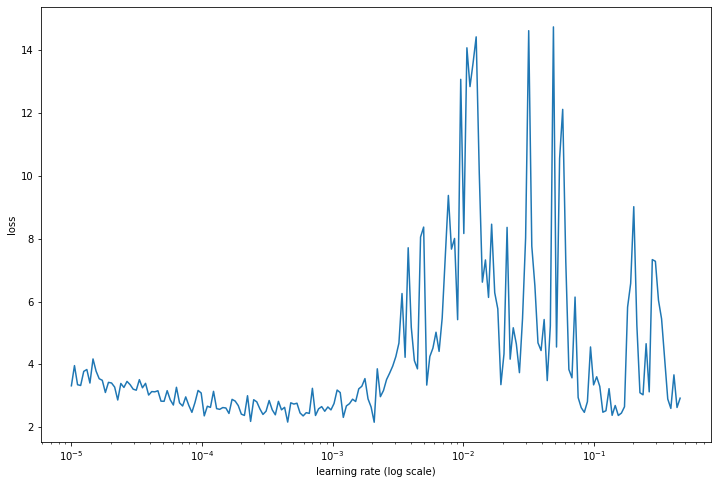

In [64]:
n_skip_beginning = 0
n_skip_end = 40

plt.figure(figsize=(12, 8))
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")
x = lrs[n_skip_beginning:-n_skip_end]
y = losses[n_skip_beginning:-n_skip_end]
plt.plot(x, y)
plt.xscale('log')

## Graphics

Epoch:  9
Training loss over epoch: 0.9667631387710571, Training acc over epoch: 0.7499207854270935
Val loss over epoch: 2.3217992782592773, Val acc over epoch: 0.24305732548236847


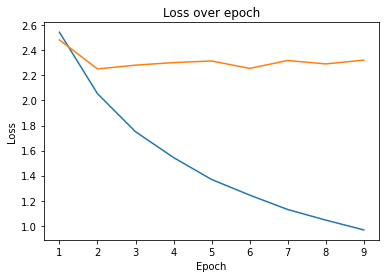

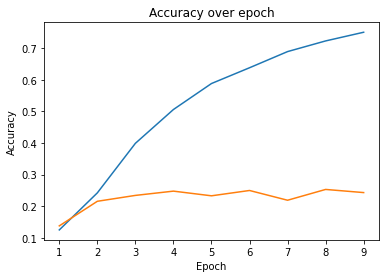

KeyboardInterrupt: ignored

In [12]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense.hdf5")

Явное переобучение, попробуем немного другую конфигурацию с меньшим числом обучаемых параметров

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 22)
  config.add_hparam("ratio", ([2] + [1] * 10) * 2)
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 1e-4)
  
  return config

In [6]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)

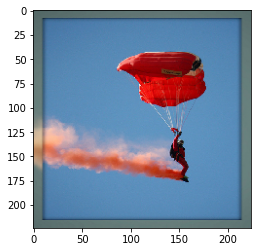

In [7]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

new_y = tf.concat([logits, nuisance], axis=1)
res_x = model.get_x(new_y)

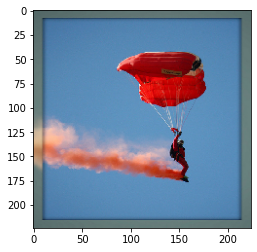

In [8]:
plt.imshow(x[0])

In [9]:
np.max(abs(res_x - x0[0]))

0.00095671415

In [0]:
zeros = np.zeros((1, *config.input_shape))
zeros = tf.convert_to_tensor(zeros, dtype=config.dtype)
zeros_logits, _ = model(zeros, training=False)

shift = 4
size = 10
for x_step in range(config.input_shape[0] // shift):
  curr = np.zeros((1, *config.input_shape))
  curr[:, x_step*shift:x_step*shift + size, x_step*shift:x_step*shift + size,  :] = 1.

  curr = tf.convert_to_tensor(curr, dtype=config.dtype)
  curr_logits, _ = model(curr, training=False)
  if np.sum(np.abs(zeros_logits.numpy() - curr_logits.numpy())) == 0:
    print("Coordinates with zero diff: x - ", x_step*shift, " y - ", x_step*shift)

In [11]:
import tensorflow.keras.backend as K
import math
import tqdm 

start_lr = 0.00001
end_lr = 100
max_val_acc = None
lr = start_lr
lr_mult = (end_lr / start_lr) ** (1 / int(np.ceil(train.samples / train.batch_size)))
lrs = []
losses = []
best_loss = 1e9

optimizer = tf.keras.optimizers.SGD(learning_rate=start_lr)

for step in tqdm.trange(int(np.ceil(train.samples / train.batch_size))):
    x_batch_train, y_batch_train = train.next()

    grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
    optimizer.apply_gradients(zip(grads, vars_))

    lrs.append(lr)
    losses.append(loss)

    if math.isnan(loss) or loss > best_loss * 1000:
        break
    
    if loss < best_loss:
        best_loss = loss

    lr *= lr_mult
    K.set_value(optimizer.lr, lr)

 85%|████████▌ | 252/296 [16:28<02:51,  3.90s/it]

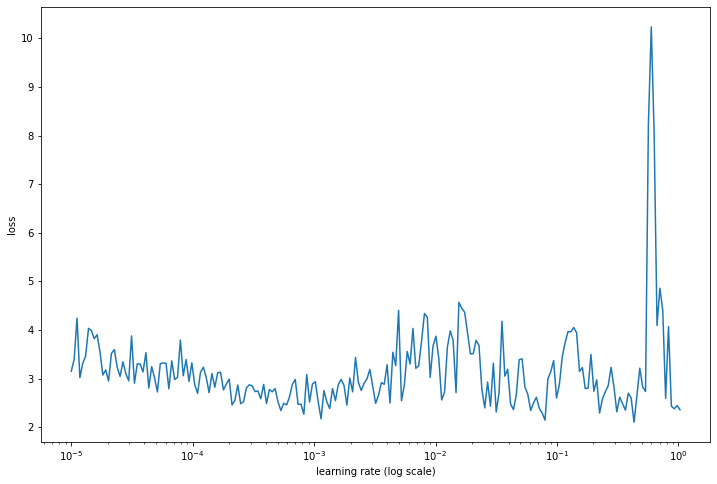

In [12]:
n_skip_beginning = 0
n_skip_end = 40

plt.figure(figsize=(12, 8))
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")
x = lrs[n_skip_beginning:-n_skip_end]
y = losses[n_skip_beginning:-n_skip_end]
plt.plot(x, y)
plt.xscale('log')

Epoch:  7
Training loss over epoch: 1.8913116455078125, Training acc over epoch: 0.3622346520423889
Val loss over epoch: 2.1520400047302246, Val acc over epoch: 0.23235668241977692


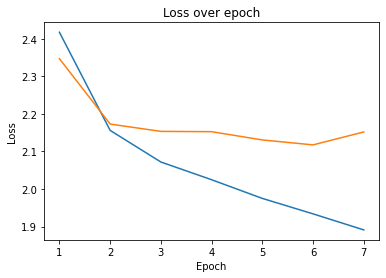

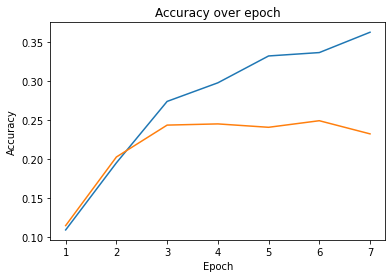

In [0]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_second.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_second.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/curr_revnet_without_dense_second.hdf5")

Epoch:  14
Training loss over epoch: 1.4036531448364258, Training acc over epoch: 0.593304455280304
Val loss over epoch: 2.243724822998047, Val acc over epoch: 0.2315923571586609


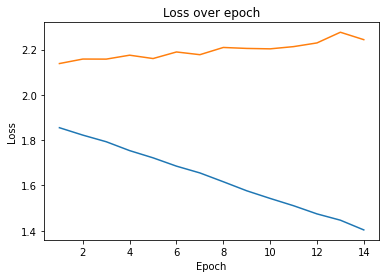

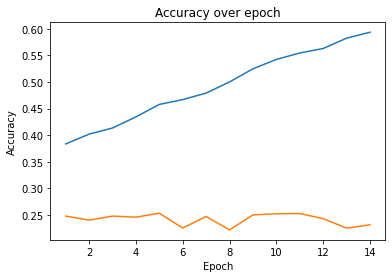

In [0]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_second.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_second.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/curr_revnet_without_dense_second.hdf5")

Пока что все равно сильное переобучение остается.

Посчитаем выходы сети, а также выведем веса:

In [0]:
def count_output_stats(model, data):
    print('{:41} {:7} {:7} {:7}'.format("Layer_name", "Mean", "Std", "AbsMax"))
    x = model.layers[0](data)
    print('{:40} {: .4f} {: .4f} {: .4f}'.format(model.layers[0].name, np.mean(x), np.std(x), np.max(np.abs(x))))

    for i, layer in enumerate(model.layers[1:-1]):
      if config.ratio[i] > 1:
        x = tf.nn.space_to_depth(x, config.ratio[i])
      x = layer(x)
      print('{:40} {: .4f} {: .4f} {: .4f}'.format(layer.name, np.mean(x), np.std(x), np.max(np.abs(x))))
    
    x = model.layers[-1](x)
    print('{:40} {: .4f} {: .4f} {: .4f}'.format(model.layers[-1].name, np.mean(x), np.std(x), np.max(np.abs(x))))

In [73]:
x_batch_train, y_batch_train = train.next()
count_output_stats(model, x_batch_train)

Layer_name                                Mean    Std     AbsMax 
init                                      0.0383  0.2004  0.9090
rev_block                                 0.0540  0.7629  7.2161
rev_block_1                               0.1175  1.0884  14.5938
rev_block_2                               0.1719  1.3505  21.8567
rev_block_3                               0.1917  1.5440  23.7656
rev_block_4                               0.2086  1.7186  29.2781
rev_block_5                               0.2192  1.8292  34.5282
rev_block_6                               0.2059  1.9709  34.9771
rev_block_7                               0.1846  2.0702  34.2742
rev_block_8                               0.1567  2.1749  37.3238
rev_block_9                               0.1089  2.2818  44.8782
rev_block_10                              0.1044  2.3746  45.0847
rev_block_11                              0.1159  2.4653  51.0374
rev_block_12                              0.1188  2.5504  55.1833
rev_block_13

In [0]:
def count_weights_stats(model):
    print('{:41} {:7} {:7} {:7}'.format("Layer_name", "Mean", "Std", "AbsMax"))
    for layer in model.layers:
      for weights in layer.weights:
        name = weights.name
        weights = weights.numpy()
        print('{:40} {: .4f} {: .4f} {: .4f}'.format(name, np.mean(weights), np.std(weights), np.max(np.abs(weights))))

In [71]:
count_weights_stats(model)

Layer_name                                Mean    Std     AbsMax 
conv2d/kernel:0                           0.0293  0.2504  0.4149
batch_normalization/gamma:0               1.0000  0.0036  1.0106
batch_normalization/beta:0               -0.0003  0.0051  0.0115
batch_normalization/moving_mean:0         0.0385  0.1619  0.4029
batch_normalization/moving_variance:0     0.0126  0.0137  0.0640
conv2d_1/kernel:0                        -0.0004  0.0420  0.0846
batch_normalization_1/gamma:0             1.0000  0.0037  1.0092
batch_normalization_1/beta:0             -0.0002  0.0037  0.0118
batch_normalization_1/moving_mean:0      -0.0690  0.4202  0.8508
batch_normalization_1/moving_variance:0   0.3475  0.2435  1.5265
conv2d_2/kernel:0                         0.0001  0.0419  0.0848
batch_normalization_2/gamma:0             1.0000  0.0030  1.0082
batch_normalization_2/beta:0              0.0001  0.0027  0.0061
batch_normalization_2/moving_mean:0       0.0525  0.3941  1.0527
batch_normalization_2/mo

### Атака

In [0]:
test = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))

Found 3925 images belonging to 10 classes.


In [0]:
x, y = test.next()

x0 = tf.reshape(x[0], (1, *config.input_shape))
logits, _ = model(x0, training=False)
print("Real class: ", int(y[0]))
print("Predicted class: ", np.argmax(logits))
plt.imshow(x0[0])
plt.show()

x1 = tf.reshape(x[1], (1, *config.input_shape))
nuisance = model.get_nuisance(x1)
logits_x1, _ = model(x1, training=False)
print("Real class: ", int(y[1]))
print("Predicted class: ", np.argmax(logits_x1))
plt.imshow(x1[0])
plt.show()

print("Metameric image")
new_y = tf.concat([logits, nuisance], axis=1)
res_x = model.get_x(new_y)
plt.show()